In [58]:
%matplotlib inline
import seaborn as sns

In [59]:
import numpy as np
import random

### Read MNIST

In [60]:
import os
import struct
import array
import numpy

def read(digits, dataset="training", path="."):
    """Loads MNIST files into 3D numpy arrays.
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    Source: http://g.sweyla.com/blog/2012/mnist-numpy/
    MNIST: http://yann.lecun.com/exdb/mnist/
    **Parameters**
        :digits: list; digits we want to load
        :dataset: string; 'training' or 'testing'
        :path: string; path to the data set files
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    _, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [k for k in xrange(size) if lbl[k] in digits]
    N = len(ind)

    images = numpy.zeros((N, rows*cols), dtype=numpy.uint8)
    labels = numpy.zeros((N, 1), dtype=numpy.int8)
    for i in xrange(len(ind)):
        images[i] = numpy.array(img[ind[i]*rows*cols:
                                (ind[i]+1)*rows*cols])
        labels[i] = lbl[ind[i]]

    return images / 255.0, labels.flatten()

In [61]:
x_train, y_train = read(list(range(10)), "training", path="../../data/")
x_test, y_test = read(list(range(10)), "testing", path="../../data/")

In [62]:
y_train_t = np.zeros((60000,10))

In [63]:
for i,val in enumerate(y_train):
    y_train_t[i][val] = 1

### Activation funcs and their mapping

In [101]:
sigmoid = lambda z: 1.0/(1.0+np.exp(-z))
sigmoid_prime = lambda z: sigmoid(z)*(1-sigmoid(z))
funny_tanh = lambda z: 1.7159 * np.tanh(2.0/3.0 * z) + .001*z
funny_tanh_prime = lambda z: 1.7159 * 2.0 / 3.0 * (1.0 / np.cosh(2.0/3.0 * z))**2 + .001
relu = lambda z: z * (z > 0)
relu_prime = lambda z: z >= 0
leaky_relu = lambda z: np.maximum(.1*z, z)
leaky_relu_prime = lambda z: 1*(z>=0) + .1*(z<0)

In [103]:
afunc_mapping = {
    "sigmoid": [sigmoid, sigmoid_prime],
    "tanh": [funny_tanh, funny_tanh_prime],
    "relu": [relu, relu_prime],
    "leaky_relu": [leaky_relu, leaky_relu_prime]
}

In [ ]:
x = np.linspace(-10,10,200)
sns.plt.plot(x, afunc_mapping["relu"][0](x))
sns.plt.plot(x, afunc_mapping["relu"][1](x))

### Create Neural Network class

In [95]:
class NeuralNetwork():
    def __init__(self, layers_sizes, afunc):
        self.layers_num = len(layers_sizes)
        self.layers_sizes = layers_sizes
        # x -> fan-out, y-> fan-in
        self.weights = [np.random.randn(x,y)/np.sqrt(y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.biases = [np.random.randn(x) for x in layers_sizes[1:]]
        self.afunc = afunc_mapping[afunc][0]
        self.afunc_prime = afunc_mapping[afunc][1]
        
        
    
    def forward_prop(self, x):
        activations = x
        for W, bias in zip(self.weights, self.biases):
            activations = self.afunc(W.dot(activations) + bias)
        return activations
    
    def classification_accuracy(self, x_test = x_test, y_test = y_test):
        predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_test])
        return sum(predictions == y_test) * 1.0 / len(y_test)
    
    def cost_prime(self, a_L, y_true):
        """ Return the vector d(Loss) / d(a_L)"""
        return a_L - y_true
    
    def backprop(self, x, y_true):
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        activations = [x]
        zs = []
        # Forward prop
        activation = x

        for W, bias in zip(self.weights, self.biases):
            z = W.dot(activation) + bias
            zs.append(z)
            activation = self.afunc(z)
            activations.append(activation)
        
        # Now do backprop
        delta = self.cost_prime(activations[-1], y_true) #* self.afunc_prime(zs[-1])
        biases_diff[-1] = delta
        weights_diff[-1] = np.outer(delta, activations[-2])
        
        for layer in xrange(2, self.layers_num):
            z = zs[-layer]
            sp = self.afunc_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            biases_diff[-layer] = delta
            weights_diff[-layer] = np.outer(delta, activations[-(layer+1)])

        return weights_diff, biases_diff
    
    def update_mini_batch(self, batch, learning_rate):
        n = len(batch)
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in batch:
            w_diff, b_diff = self.backprop(x,y)
            weights_diff = [w+dw for w, dw in zip(weights_diff, w_diff)]
            biases_diff = [b+db for b, db in zip(biases_diff, b_diff)]
            
        self.weights = [w - learning_rate*dw/n for w,dw in zip(self.weights, weights_diff)]
        self.biases = [b - learning_rate*db/n for b,db in zip(self.biases, biases_diff)]
    
    def SGD(self, train_data, batch_size = 10, epochs = 10, learning_rate = .1, test_data = None):
        if test_data:
            x_test, y_test = test_data
        n = len(train_data)
        for epoch in xrange(epochs):
            random.shuffle(train_data)
            mini_batches = [train_data[i:i+batch_size] for i in xrange(0,n,batch_size)]
            
            for batch in mini_batches:
                self.update_mini_batch(batch, learning_rate)
                
            if test_data:
                print "Epoch %s: Test accuracy = %s" % (epoch, self.classification_accuracy())
            else:
                print "Epoch %s" % epoch

In [104]:
clf = NeuralNetwork([784,30,10], "leaky_relu")

In [74]:
train_data = list(zip(x_train, y_train_t))
test_data = [x_test, y_test]

In [107]:
clf.SGD(train_data, test_data=test_data, learning_rate = .001, epochs=30, batch_size = 10)

Epoch 0: Test accuracy = 0.9519
Epoch 1: Test accuracy = 0.9515
Epoch 2: Test accuracy = 0.9513
Epoch 3: Test accuracy = 0.9517
Epoch 4: Test accuracy = 0.9514
Epoch 5: Test accuracy = 0.9519
Epoch 6: Test accuracy = 0.9512


KeyboardInterrupt: 

In [206]:
clf.forward_prop(x_test[1000]).argmax()

9

In [199]:
%matplotlib inline
import seaborn as sns

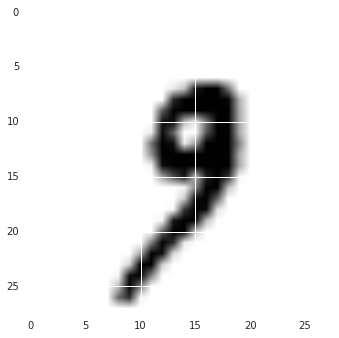

In [204]:
sns.plt.imshow(x_test[1000].reshape((28,28)))

In [195]:
clf.classification_accuracy()

0.098000000000000004

### Trying Deepx

In [1]:
from deepx.nn import *

In [115]:
mlp = Vector(784) >> Sigmoid(100) >> Softmax(10)

In [12]:
mlp

Vector<784> >> Tanh(784, 200) >> Softmax(200, 10)

In [5]:
from deepx.loss import *
from deepx.optimize import *

In [116]:
loss = CrossEntropy()
rmsprop = RMSProp(mlp, loss)

In [16]:
x_train.shape

(60000, 784)

In [18]:
y_train = y_train.reshape(60000,1)

In [131]:
for i in xrange(20):
    print rmsprop.train(x_train, Y, 40)

8.07009792328
8.04849815369
7.99539518356
7.91867208481


KeyboardInterrupt: 

In [126]:
results = np.array([i.argmax() for i in mlp.predict(x_test)])
print sum(results == y_test) * 1.0 / len(y_test) 


0.8923


In [114]:
mlp.predict(x_train)[0]

array([  3.47602321e-03,   3.54317344e-05,   2.22870847e-03,
         1.66611955e-01,   2.08737947e-06,   8.22107196e-01,
         9.42161278e-05,   9.23766464e-04,   3.65296449e-03,
         8.67654686e-04], dtype=float32)